(sec_guide_abc)=
# An ABC analysis

This page shows how to do an Abstract Bayesian Computation (ABC) analysis,
where the discriminator output is used as a measure of similarity
to the target dataset.
* We'll continue to use the two-parameter
  bottleneck model from the [](sec_guide_creating_a_dinf_model) page.
* Dinf saves the discriminator predictions as a [numpy `.npz`](numpy:numpy.save)
  file, which we'll load back into Python for exploratory analysis.
* We'll also plot the results with the `dinf-plot` command.

The results below were obtained using 80 Xeon 6248 CPU cores for simulations,
and a Tesla T4 GPU for training and applying the neural network.

## Training the discriminator

Using the `dinf train` subcommand, we'll train the
discriminator on a large number of replicates.
We'll use 1 million training replicates and 20,000 test replicates,
and also set the seed for the random number generator to obtain
reproducible results. This will train the discriminator on 500,000
samples from the generator (with parameter values sampled from the prior
distribution) and 500,000 samples from the target dataset
(using the `truth` parameter values, as this is a simulation-only model).

In [1]:
%%bash
mkdir -p out/abc
rm -f out/abc/bottleneck.nn
time dinf train \
    --epochs 20 \
    --training-replicates 1000000 \
    --test-replicates 20000 \
    ../../examples/bottleneck/model.py \
    out/abc/bottleneck.nn

[epoch 1|1000000] train loss 0.0517, accuracy 0.9841; test loss 0.0304, accuracy 0.9927
[epoch 2|1000000] train loss 0.0340, accuracy 0.9906; test loss 0.0409, accuracy 0.9901
[epoch 3|1000000] train loss 0.0285, accuracy 0.9920; test loss 0.0290, accuracy 0.9929
[epoch 4|1000000] train loss 0.0252, accuracy 0.9930; test loss 0.0253, accuracy 0.9934
[epoch 5|1000000] train loss 0.0231, accuracy 0.9936; test loss 0.0246, accuracy 0.9933
[epoch 6|1000000] train loss 0.0216, accuracy 0.9940; test loss 0.0243, accuracy 0.9946
[epoch 7|1000000] train loss 0.0205, accuracy 0.9942; test loss 0.0389, accuracy 0.9874
[epoch 8|1000000] train loss 0.0195, accuracy 0.9945; test loss 0.0247, accuracy 0.9929
[epoch 9|1000000] train loss 0.0188, accuracy 0.9948; test loss 0.0261, accuracy 0.9939
[epoch 10|1000000] train loss 0.0180, accuracy 0.9950; test loss 0.0267, accuracy 0.9938
[epoch 11|1000000] train loss 0.0175, accuracy 0.9951; test loss 0.0243, accuracy 0.9944
[epoch 12|1000000] train loss 


real	27m4.347s
user	1098m22.286s
sys	29m18.701s


The output `.nn` file is the trained discriminator, which contains the trained
network's weights and some additional metadata such as the loss and accuracy.

In [2]:
%%bash
dinf-plot metrics \
    --output-file /tmp/metrics.svg \
    out/abc/bottleneck.nn

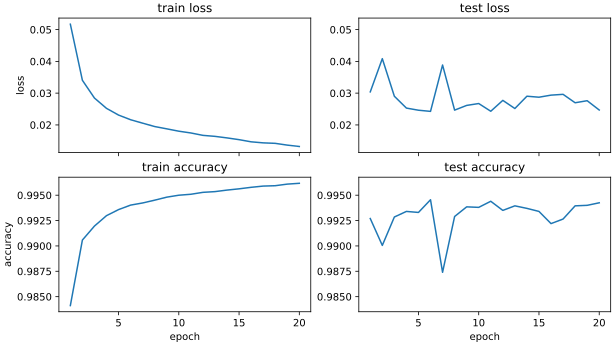

In [3]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/metrics.svg"))

## Sampling from the prior and measuring similarity

Next, we'll use the `predict` subcommand to obtain discriminator predications
for 1 million replicates from the generator (with parameter values sampled
from the prior).


In [4]:
%%bash
rm -f out/abc/bottleneck.npz
time dinf predict \
  --replicates 1000000 \
  ../../examples/bottleneck/model.py \
  out/abc/bottleneck.nn \
  out/abc/bottleneck.npz


real	20m18.754s
user	1544m11.190s
sys	30m30.008s


The output `.npz` file is an uncompressed [numpy `.npz`](numpy:numpy.save) file.
This file contains the parameter values for each replicate, and the predictions
made by the discriminator. It can be loaded back into Python using the
[`dinf.load_results()`](dinf.load_results) function.

In [5]:
import dinf

data = dinf.load_results("out/abc/bottleneck.npz")
# The returned data is a numpy structured array.
data[:5]

array([(1.1039646e-14, 19858.02350065, 29413.87476832),
       (2.6599397e-03, 10035.13322844,  3413.76299114),
       (1.0666163e-30, 28392.65227786, 21370.1867761 ),
       (5.8842200e-04,  8815.53013852,  5889.8194793 ),
       (3.6522373e-18, 19213.69026835,   498.4524939 )],
      dtype=[('_Pr', '<f4'), ('N0', '<f8'), ('N1', '<f8')])

In [6]:
# Columns correspond to the distinct parameters, and the
# special column "_Pr" contains the discriminator predictions.
data.dtype.names

('_Pr', 'N0', 'N1')

The discriminator outputs $Pr(t)$, the probability that
a given input feature is from the target distribution.
But note that the discriminator output will depend on the extent of our
parameter space. I.e. if our parameter space is just a small neighbourhood
around the true parameter values, then the discriminator will have a hard
time distinguishing the two datasets and thus produce few $Pr(t)$ values
near 0 or 1.
On the other hand, the discriminator might actually be too good
because of [model misspecification](sec_guide_misspecification),
in which case there will be many values near 0 and few near 1.

To see how much of our parameter space is being classified as coming
from the target dataset, lets plot the distribution of probabilities
(the `_Pr` column) as a histogram. We'll use `dinf-plot` with the `hist`
subcommand.


In [7]:
%%bash
dinf-plot hist \
    --x-param _Pr \
    --output-file /tmp/hist-Pr.svg \
    out/abc/bottleneck.npz

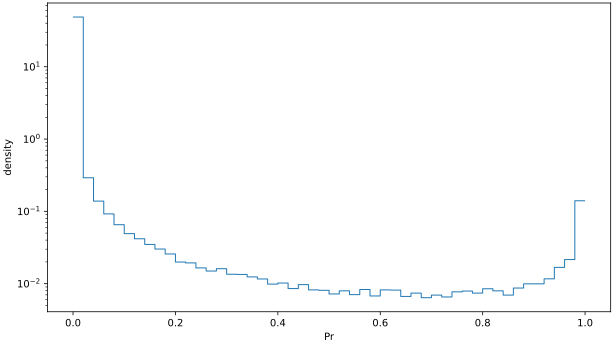

In [8]:
from IPython.display import SVG, display

display(SVG(filename=f"/tmp/hist-Pr.svg"))

## Choosing the posterior distribution

Two simple ways of choosing the posterior distribution are
- choose the $n$ samples with the highest discriminator score, or
- choose samples with a score $>x$.

Below, we'll take the top 1000 samples and look at the median value
and a 95% interval for this posterior sample.

In [9]:
import dinf
import numpy as np

data = dinf.load_results("out/abc/bottleneck.npz")

# Predictions from discriminator.
probs = data["_Pr"]
# Get the indices that sort the probabilities in ascending order.
idx = np.flip(np.argsort(data["_Pr"]))
# Posterior sample for parameters N0 and N1.
posterior = data[idx[:1_000]]

# Print median values and 95% credible intervals.
for par in ("N0", "N1"):
    lo, median, hi = np.quantile(posterior[par], [0.025, 0.5, 0.975])
    print(par, median, (lo, hi))

N0 10380.229959362801 (7246.533102422719, 14509.635453840716)
N1 189.9144451017886 (59.9375214759438, 494.37038597422594)


Recall that the `truth` values used in the model were `N0=10000`
and `N1=200`. The 95% credible intervals contain these values,
and the median values are close to the `truth`.
Note that the accuracy of the discriminator could potentially
be further improved (see [](sec_guide_accuracy)), which would
presumably lead to narrower confidence intervals and/or median
values even closer to the truth.

Manually loading the results and doing the rejection sampling
is not actually necessary. Instead, we can use `dinf-plot hist`
to filter the top $n$ samples and plot histograms of the data.

In [10]:
%%bash
dinf-plot hist \
    --top-n 1000 \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/hist-abc-top-1000.svg \
    out/abc/bottleneck.npz

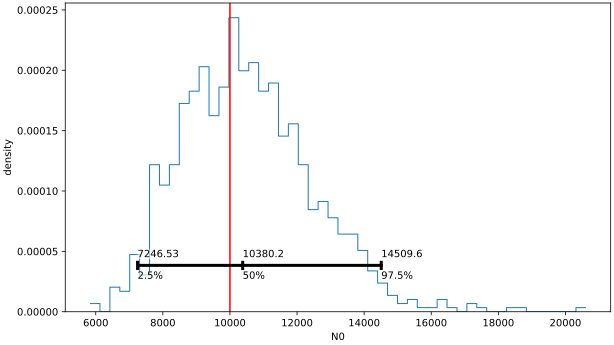

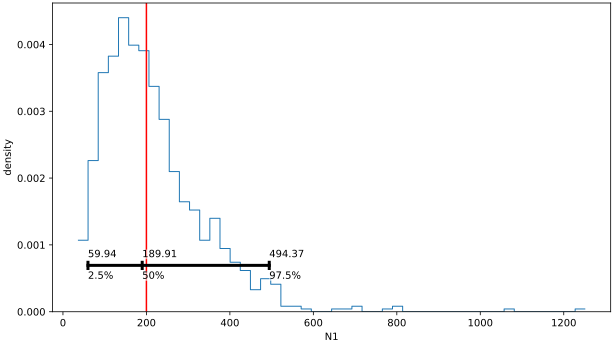

In [11]:
from IPython.display import SVG, display

for par in ("N0", "N1"):
    display(SVG(filename=f"/tmp/hist-abc-top-1000_{par}.svg"))

Finally, we'll use the `hist2d` subcommand to show both `N0` and `N1` jointly.

In [12]:
%%bash
dinf-plot hist2d \
    --top-n 1000 \
    --model ../../examples/bottleneck/model.py \
    --output-file /tmp/hist2d-abc-top-1000.svg  \
    out/abc/bottleneck.npz

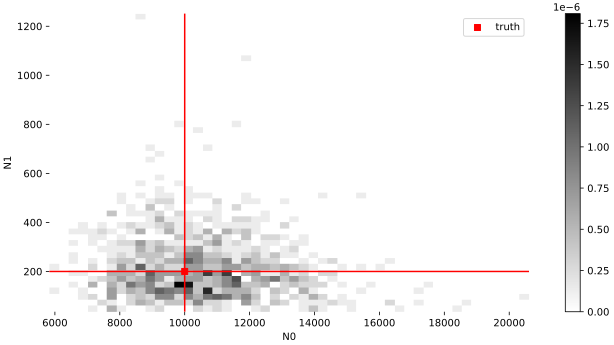

In [13]:
from IPython.display import SVG, display

display(SVG(filename="/tmp/hist2d-abc-top-1000.svg"))